In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
def load_and_explore_data(filepath):
    """
    Load the dataset and perform initial data exploration
    """
    # Load the dataset
    df = pd.read_csv('/content/cosmicclassifierTraining.csv')
    print(f"Dataset shape: {df.shape}")

    # Check for missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percent
    })
    print("\nMissing values by column:")
    print(missing_df[missing_df['Missing Values'] > 0])

    # Check data types
    print("\nData types:")
    print(df.dtypes)

    # Basic statistics for numerical columns
    print("\nNumerical feature statistics:")
    print(df.describe())

    # Check distribution of prediction classes
    if 'Prediction' in df.columns:
        prediction_counts = df['Prediction'].value_counts().sort_index()
        print("\nPrediction class distribution:")
        print(prediction_counts)

    return df


In [ ]:
def analyze_correlations(df):
    """
    Analyze correlations between features and target
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    print("\nCorrelation matrix:")
    print(corr_matrix)

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')

    # Print features most correlated with target
    if 'Prediction' in numeric_df.columns:
        target_corr = corr_matrix['Prediction'].drop('Prediction').sort_values(ascending=False)
        print("\nFeatures correlation with target (Prediction):")
        print(target_corr)

        # Plot features vs. target correlation
        plt.figure(figsize=(10, 6))
        ax = target_corr.plot(kind='bar')
        plt.title('Feature Correlation with Prediction')
        plt.xlabel('Features')
        plt.ylabel('Correlation Coefficient')
        plt.tight_layout()
        plt.savefig('feature_target_correlation.png')

    return corr_matrix


In [ ]:
def analyze_feature_class_relationships(df):
    """
    Analyze how features vary across different prediction classes
    """
    if 'Prediction' not in df.columns:
        print("No prediction column found for class analysis")
        return

    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_features.remove('Prediction')

    # Calculate mean values of each feature for each class
    class_means = {}
    for feature in numeric_features:
        class_means[feature] = df.groupby('Prediction')[feature].mean()

        # Plot mean feature value by class
        plt.figure(figsize=(10, 6))
        class_means[feature].plot(kind='bar')
        plt.title(f'Mean {feature} by Prediction Class')
        plt.xlabel('Prediction Class')
        plt.ylabel(f'Mean {feature} Value')
        plt.tight_layout()
        plt.savefig(f'{feature}_by_class.png')

    # Calculate discrimination power (variance of means)
    discrimination_power = {}
    for feature in numeric_features:
        means = class_means[feature]
        discrimination_power[feature] = means.var()

    # Sort features by discrimination power
    sorted_power = sorted(discrimination_power.items(), key=lambda x: x[1], reverse=True)
    print("\nFeatures ranked by class discrimination power:")
    for feature, power in sorted_power:
        print(f"{feature}: {power:.4f}")

    return class_means, discrimination_power




In [ ]:
def analyze_feature_interactions(df):
    """
    Analyze interactions between features
    """
    if 'Prediction' not in df.columns:
        print("No prediction column found for interaction analysis")
        return

    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_features.remove('Prediction')

    # Select top features for interaction analysis
    top_features = [
        "Surface Temperature",
        "Mineral Abundance",
        "Water Content",
        "Atmospheric Density"
    ]

    # Create and analyze interaction terms
    interaction_corrs = []
    for i, feat1 in enumerate(top_features):
        for j, feat2 in enumerate(top_features):
            if j > i:  # avoid duplicates
                if feat1 in df.columns and feat2 in df.columns:
                    # Create interaction term
                    interaction_name = f"{feat1} * {feat2}"
                    df[interaction_name] = df[feat1] * df[feat2]

                    # Calculate correlation with prediction
                    corr = df[interaction_name].corr(df['Prediction'])
                    interaction_corrs.append((interaction_name, corr))

                    # Remove interaction column to keep dataframe clean
                    df.drop(interaction_name, axis=1, inplace=True)

    # Sort by absolute correlation
    interaction_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
    print("\nFeature interactions correlation with target:")
    for name, corr in interaction_corrs:
        print(f"{name}: {corr:.4f}")

    return interaction_corrs


In [ ]:
def analyze_nonlinear_relationships(df):
    """
    Analyze potential non-linear relationships between features and target
    """
    if 'Prediction' not in df.columns:
        print("No prediction column found for non-linear analysis")
        return

    top_features = [
        "Surface Temperature",
        "Mineral Abundance",
        "Water Content",
        "Atmospheric Density"
    ]

    results = {}
    for feature in top_features:
        if feature in df.columns:
            # Create a copy with non-null values
            valid_data = df[[feature, 'Prediction']].dropna()

            # Sort by feature value
            valid_data = valid_data.sort_values(by=feature)

            # Bin the data into 10 groups by feature value
            valid_data['bin'] = pd.qcut(valid_data[feature], 10, labels=False)

            # Calculate mean target value for each bin
            bin_means = valid_data.groupby('bin').agg({
                feature: 'mean',
                'Prediction': 'mean'
            })

            results[feature] = bin_means

            # Plot the relationship
            plt.figure(figsize=(10, 6))
            plt.scatter(bin_means[feature], bin_means['Prediction'])
            plt.title(f'{feature} vs Prediction (binned)')
            plt.xlabel(feature)
            plt.ylabel('Mean Prediction')
            plt.grid(True)

            # Add trend line
            z = np.polyfit(bin_means[feature], bin_means['Prediction'], 2)
            p = np.poly1d(z)
            x_range = np.linspace(bin_means[feature].min(), bin_means[feature].max(), 100)
            plt.plot(x_range, p(x_range), "r--")

            plt.tight_layout()
            plt.savefig(f'{feature}_nonlinear.png')

    return results


In [ ]:
def create_preprocessing_pipeline(df, include_feature_engineering=True):
    """
    Create a preprocessing pipeline for the cosmic classifier dataset
    """
    # Identify column types
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if 'Prediction' in numeric_features:
        numeric_features.remove('Prediction')

    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Define custom transformer for feature engineering
    def create_interaction_features(X):
        """Create interaction features based on correlation analysis"""
        X_new = X.copy()

        # Add interaction terms for the most predictive feature pairs
        if 'Water Content' in X_new and 'Atmospheric Density' in X_new:
            X_new['Water_x_Atmos_Density'] = X_new['Water Content'] * X_new['Atmospheric Density']

        if 'Mineral Abundance' in X_new and 'Atmospheric Density' in X_new:
            X_new['Mineral_x_Atmos_Density'] = X_new['Mineral Abundance'] * X_new['Atmospheric Density']

        if 'Surface Temperature' in X_new and 'Mineral Abundance' in X_new:
            X_new['Surface_Temp_x_Mineral'] = X_new['Surface Temperature'] * X_new['Mineral Abundance']

        if 'Mineral Abundance' in X_new and 'Water Content' in X_new:
            X_new['Mineral_x_Water'] = X_new['Mineral Abundance'] * X_new['Water Content']

        # Add polynomial features for Surface Temperature (shows non-linear relationship)
        if 'Surface Temperature' in X_new:
            X_new['Surface_Temp_Squared'] = X_new['Surface Temperature'] ** 2

        return X_new

    # Create preprocessing steps for numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Create preprocessing steps for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine all preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # Drop any columns not specified
    )

    # Create the full preprocessing pipeline
    if include_feature_engineering:
        interaction_transformer = FunctionTransformer(create_interaction_features)
        full_pipeline = Pipeline(steps=[
            ('feature_engineering', interaction_transformer),
            ('preprocessor', preprocessor)
        ])
    else:
        full_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor)
        ])

    return full_pipeline




In [ ]:
def split_and_preprocess_data(df, pipeline, test_size=0.2, random_state=42):
    """
    Split the data into train and test sets, and apply preprocessing
    """
    # Check if 'Prediction' column exists
    if 'Prediction' not in df.columns:
        raise ValueError("No 'Prediction' column found in the dataset")

    # Split features and target
    X = df.drop('Prediction', axis=1)
    y = df['Prediction'].copy()

    # Handle missing values in the target
    mask = ~y.isna()
    X = X[mask]
    y = y[mask].astype(int)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Fit the preprocessing pipeline on the training data
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)

    print(f"\nPreprocessed training data shape: {X_train_processed.shape}")
    print(f"Preprocessed test data shape: {X_test_processed.shape}")

    # Count number of samples per class in training set
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    print("\nClass distribution in training set:")
    for class_label, count in sorted(class_distribution.items()):
        print(f"Class {class_label}: {count} samples")

    return X_train_processed, X_test_processed, y_train, y_test




In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    """
    Train an XGBoost classifier and evaluate on the test set.
    """
    print("\n=== Training XGBoost Model ===")
    model = XGBClassifier(objective='multi:softmax',num_class=10, random_state=42, eval_metric="merror")

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")
    print(f"Average cross-validation score: {scores.mean():.4f}")

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    return model,accuracy


=== Processing dataset: cosmicclassifierTraining.csv ===
Dataset shape: (60000, 11)

Missing values by column:
                               Missing Values  Percentage
Atmospheric Density                      2984    4.973333
Surface Temperature                      3032    5.053333
Gravity                                  2984    4.973333
Water Content                            3077    5.128333
Mineral Abundance                        2921    4.868333
Orbital Period                           2997    4.995000
Proximity to Star                        2945    4.908333
Magnetic Field Strength                  3058    5.096667
Radiation Levels                         3021    5.035000
Atmospheric Composition Index            2942    4.903333
Prediction                               3039    5.065000

Data types:
Atmospheric Density              float64
Surface Temperature              float64
Gravity                          float64
Water Content                    float64
Mineral Abundanc

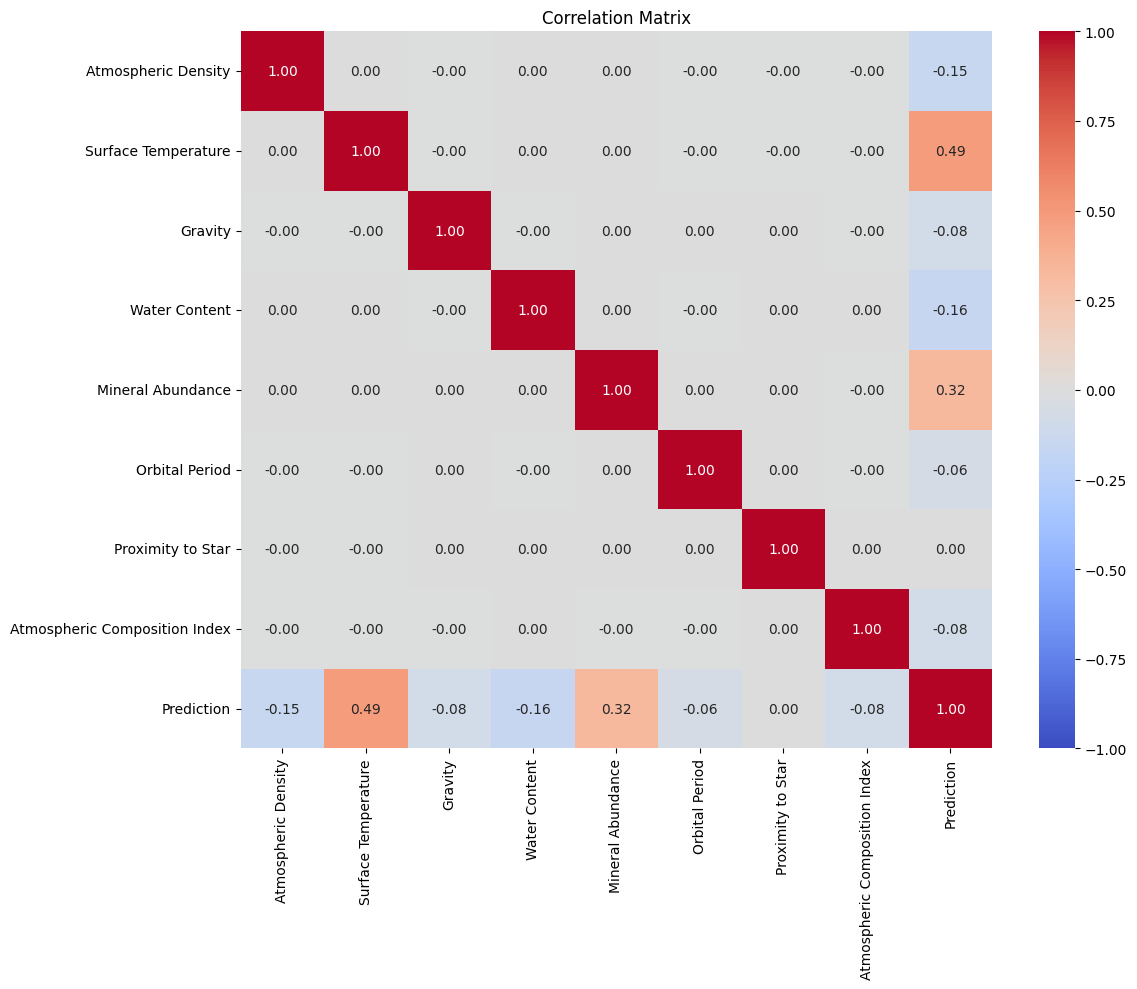

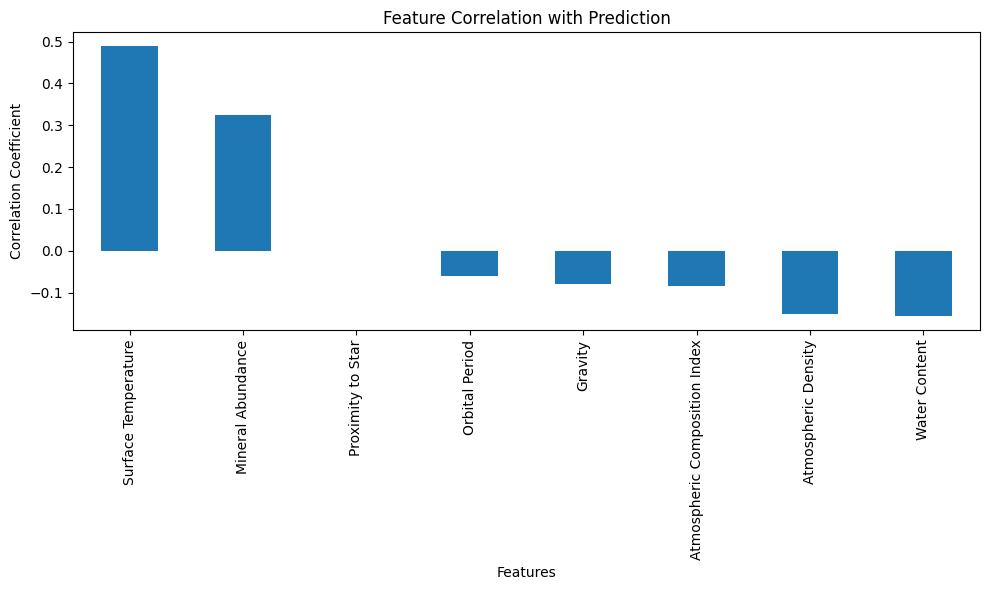

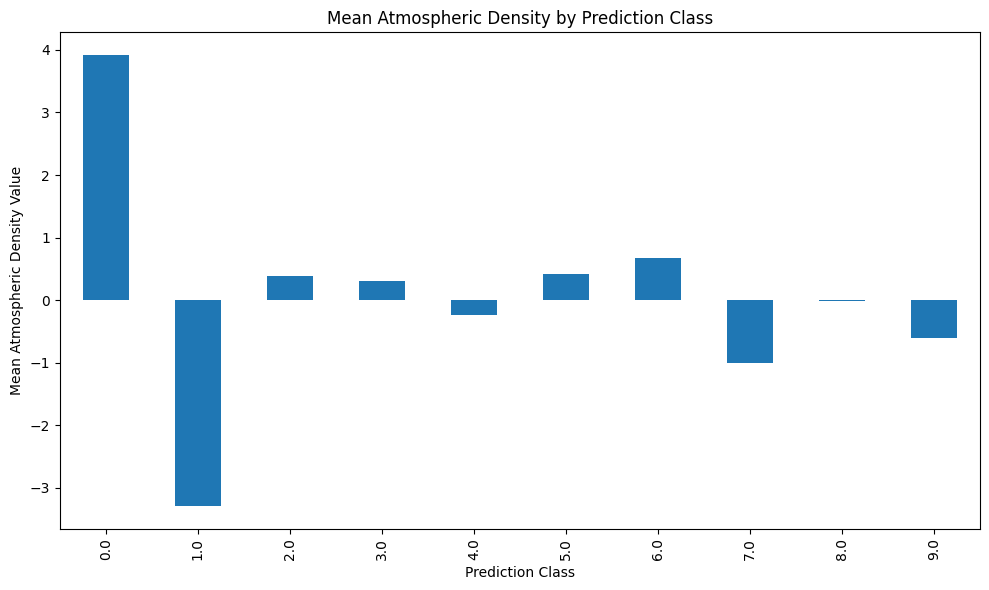

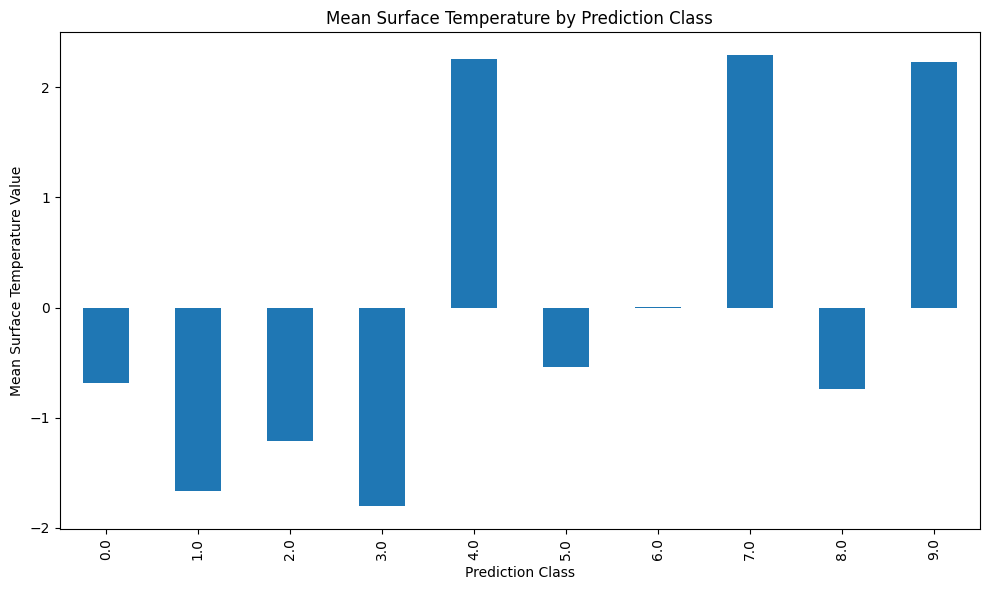

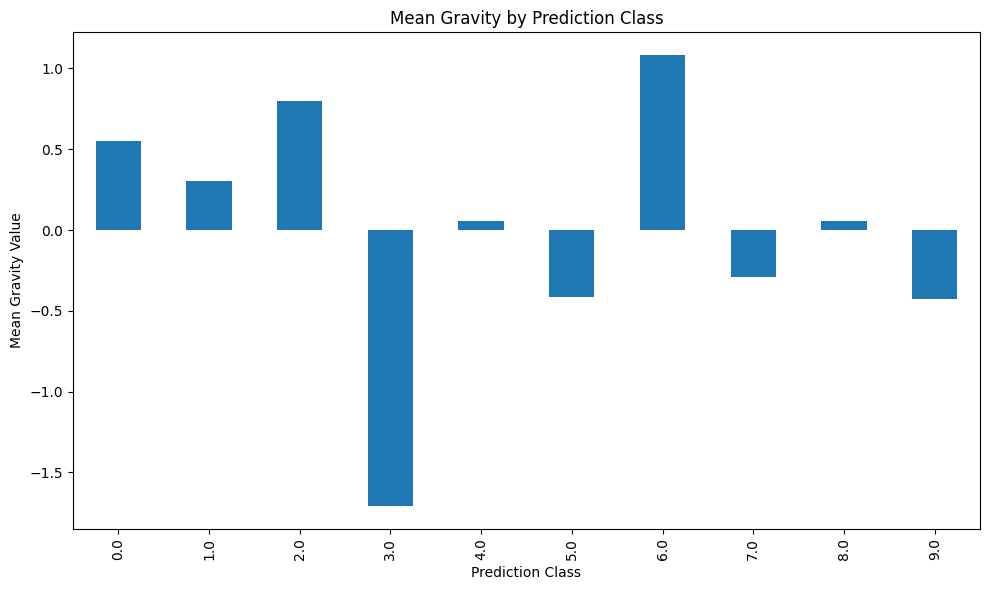

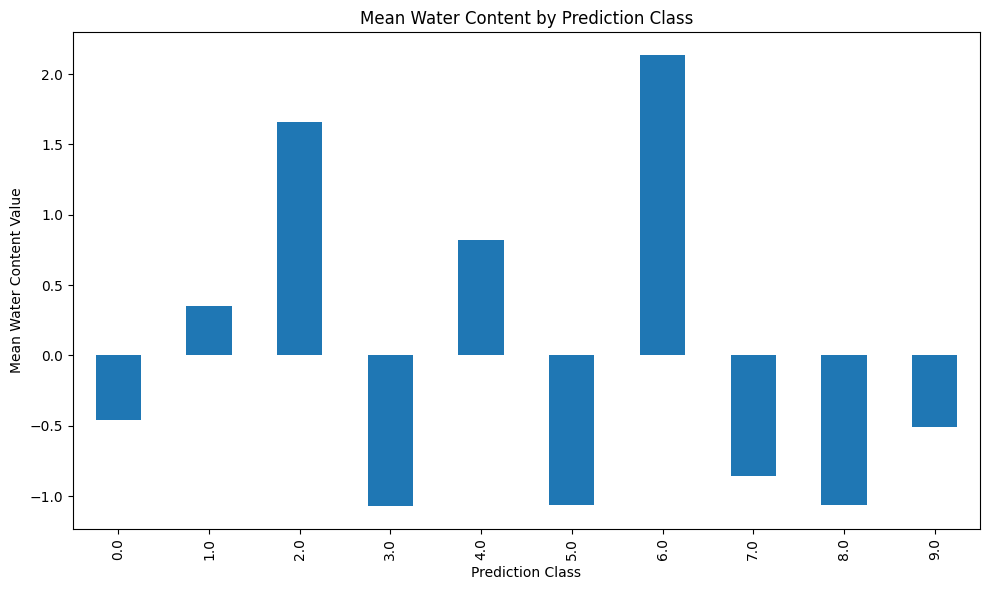

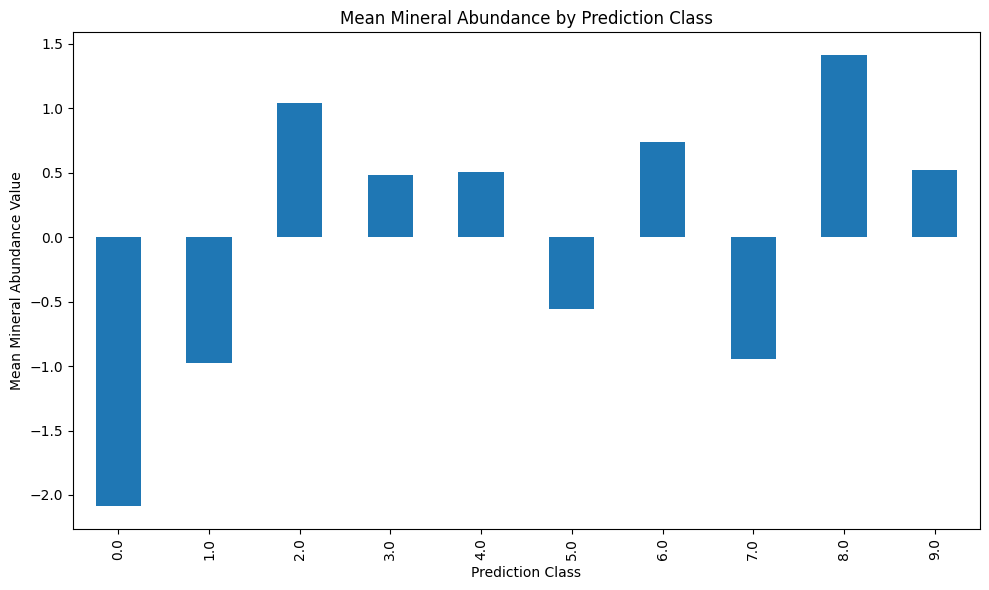

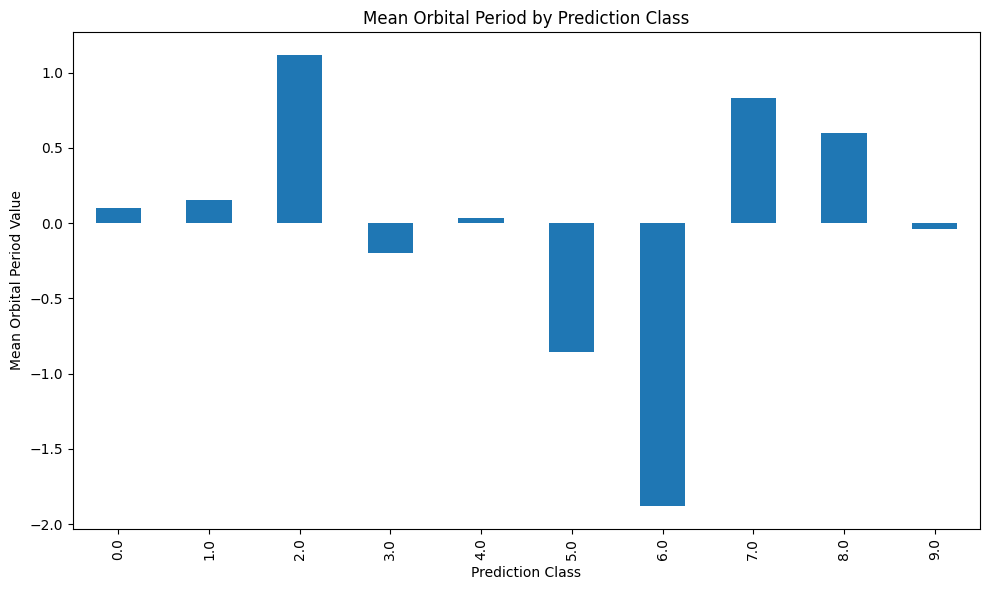

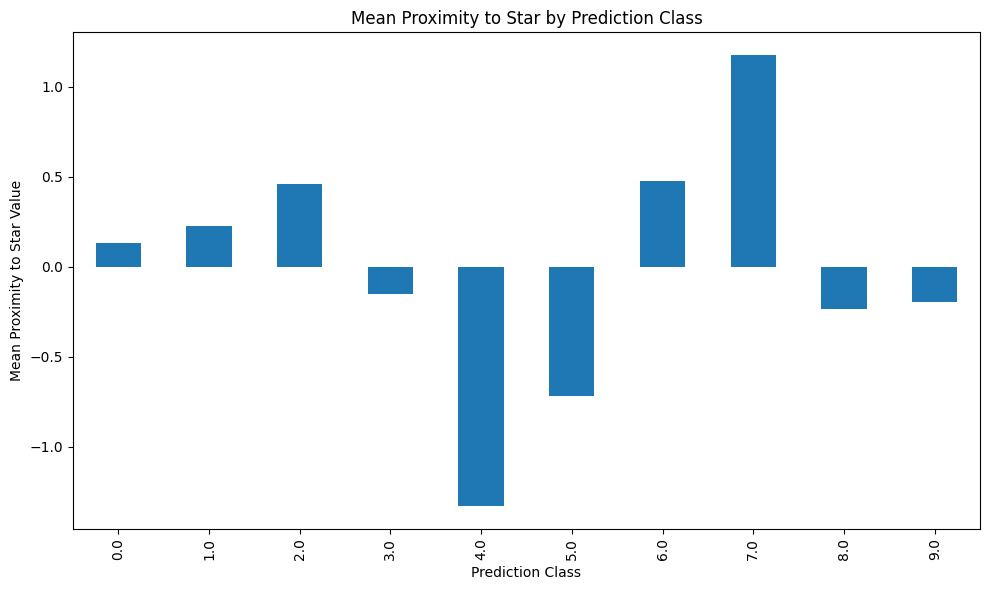

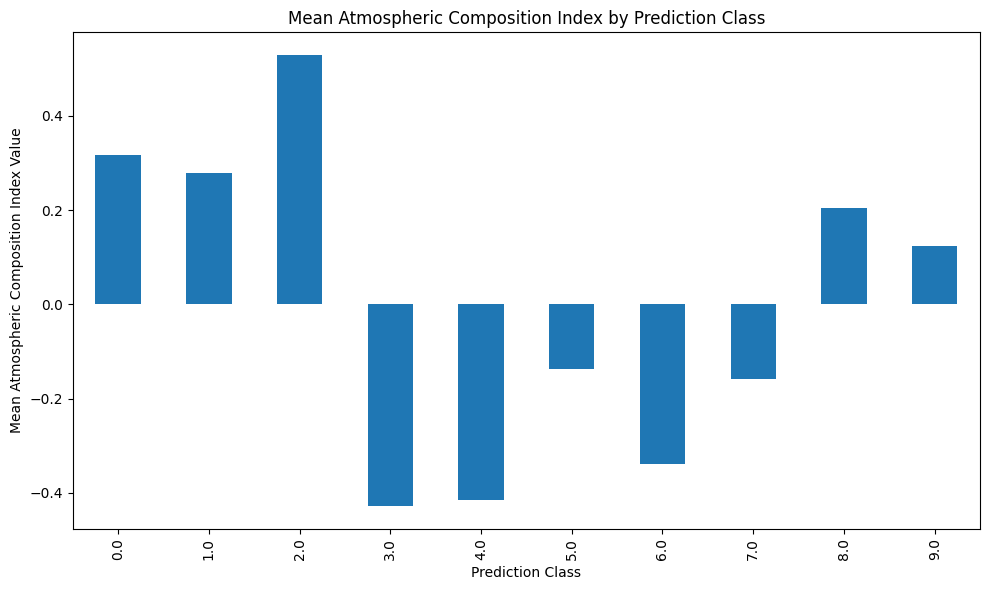

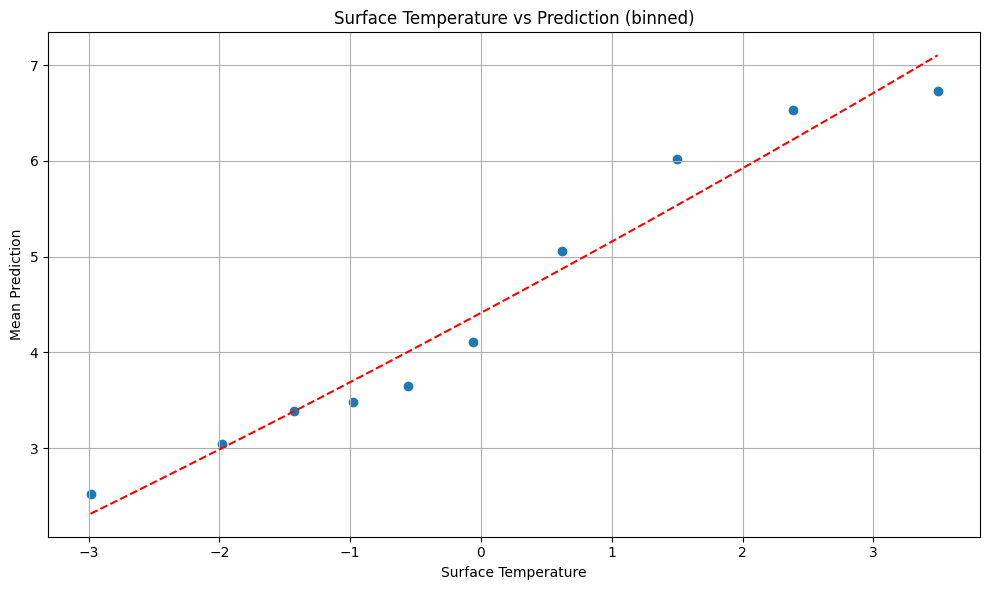

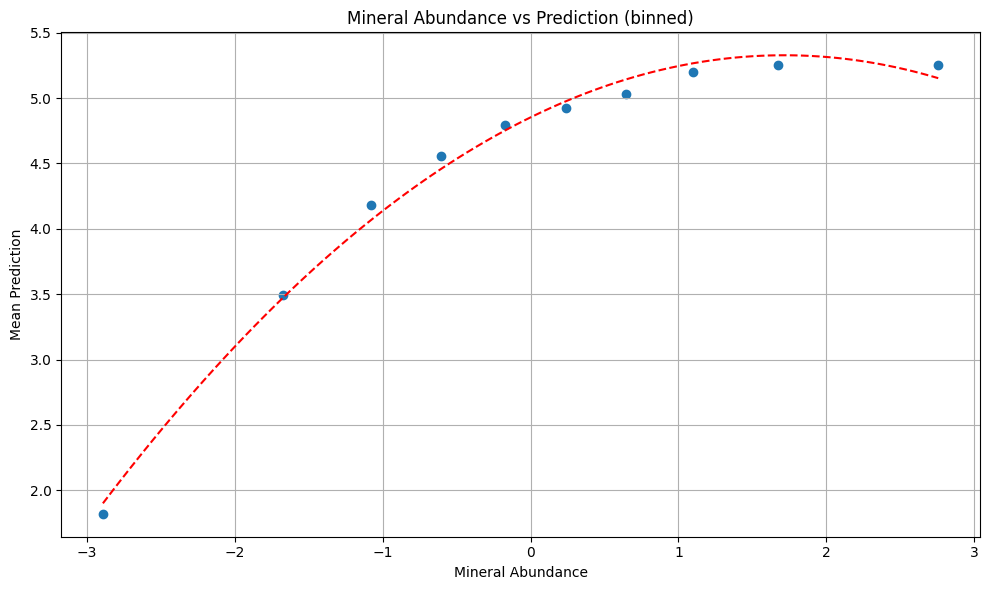

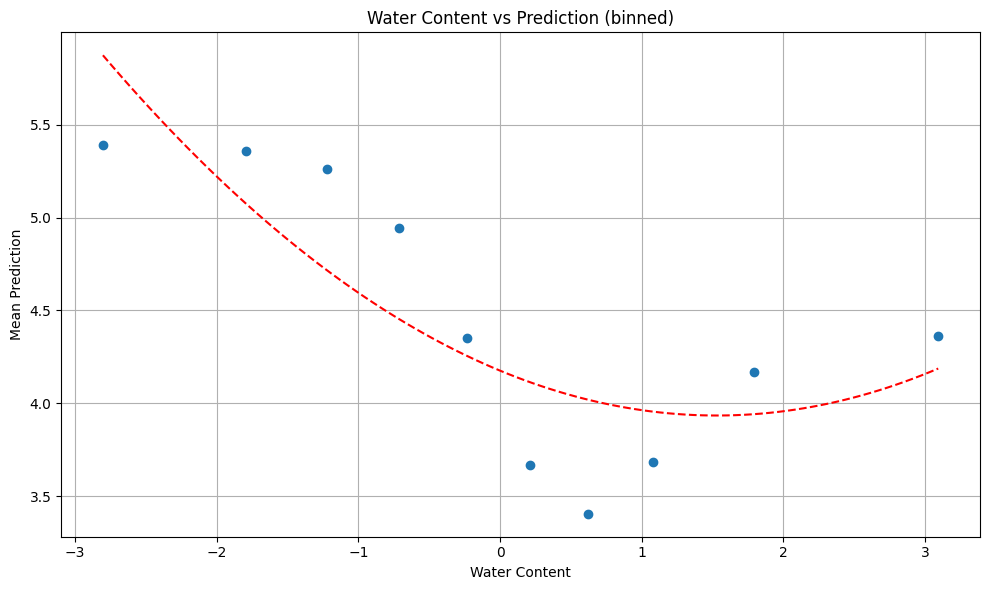

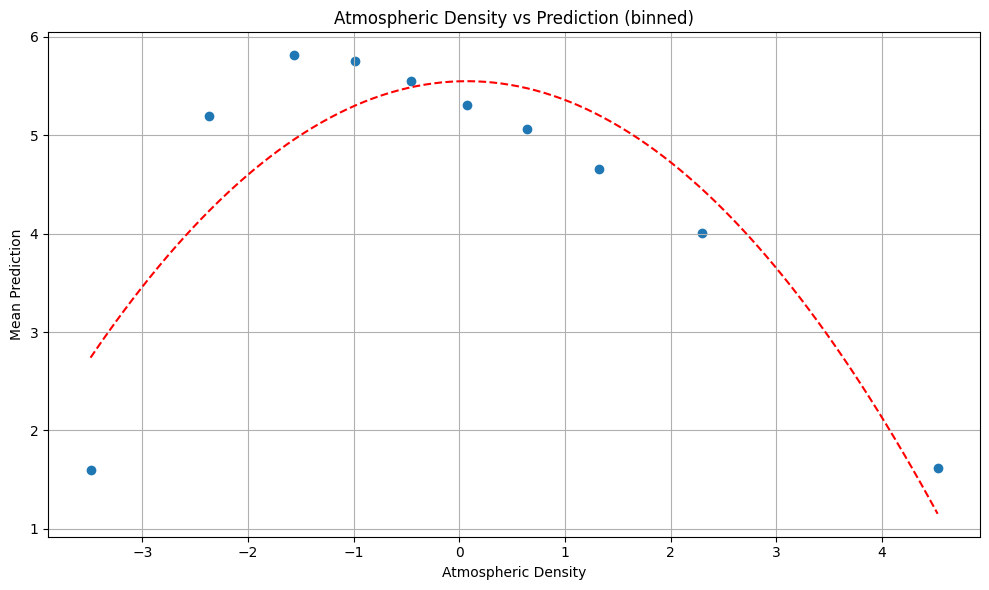

In [ ]:
def main(train_filepath='cosmicclassifierTraining.csv',test_filepath='cosmicclassifierTest.csv'):
    """
    Main function to run the entire analysis and preprocessing pipeline
    """
    print(f"=== Processing dataset: {train_filepath} ===")

    # Load and explore the data
    df = load_and_explore_data(train_filepath)

    # Analyze correlations
    print("\n=== Correlation Analysis ===")
    correlation_matrix = analyze_correlations(df)

    # Analyze feature-class relationships
    print("\n=== Feature-Class Relationship Analysis ===")
    class_means, discrimination_power = analyze_feature_class_relationships(df)

    # Analyze feature interactions
    print("\n=== Feature Interaction Analysis ===")
    interaction_correlations = analyze_feature_interactions(df)

    # Analyze non-linear relationships
    print("\n=== Non-linear Relationship Analysis ===")
    nonlinear_results = analyze_nonlinear_relationships(df)

    # Create preprocessing pipeline
    print("\n=== Creating Preprocessing Pipeline ===")
    pipeline = create_preprocessing_pipeline(df)

    # Split and preprocess data
    print("\n=== Preprocessing Data ===")
    X_train, X_test, y_train, y_test = split_and_preprocess_data(df, pipeline)

    # XGBoost
    print("\n=== Training and Evaluating XGBoost Model ===")
    model, accuracy = train_and_evaluate_xgboost(X_train, X_test, y_train, y_test)

    print(f"\n=== Processing Test Dataset: {test_filepath} ===")

    # Load the test dataset
    test_df = pd.read_csv(test_filepath)

    # Extract features from test dataset
    X_test_final = pipeline.transform(test_df.drop(columns=['Planet_ID'], errors='ignore'))  # Exclude 'Planet_ID' if present

    # Make predictions
    y_pred = model.predict(X_test_final)

    # Create submission.csv
    submission = pd.DataFrame({
        "Planet_ID":test_df.index,
        "Predicted_Class": y_pred
    })
    submission.to_csv("submission.csv", index=False)

    print("\n✅ Submission file created successfully: submission.csv")

    print("\n=== Analysis and Preprocessing Complete ===")
    print("Generated visualization files:")
    print("- correlation_heatmap.png")
    print("- feature_target_correlation.png")
    print("- *_by_class.png (for each numeric feature)")
    print("- *_nonlinear.png (for top features)")

    return X_train, X_test, y_train, y_test, pipeline , model, accuracy


if __name__ == "__main__":
    X_train, X_test, y_train, y_test, pipeline , model,accuracy= main()

In [ ]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### CatBoost Model

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

def train_and_evaluate_catboost(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a CatBoost model
    """
    print("\n=== Training CatBoost Model ===")

    model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)
    model.fit(X_train, y_train)

    print("\n=== Evaluating CatBoost Model ===")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"CatBoost Accuracy: {accuracy:.4f}")

    return model, accuracy


In [ ]:
train_and_evaluate_catboost(X_train, X_test, y_train, y_test)


=== Training CatBoost Model ===
0:	learn: 2.1564825	total: 152ms	remaining: 1m 15s
100:	learn: 0.6777255	total: 21.4s	remaining: 1m 24s
200:	learn: 0.5314378	total: 38.5s	remaining: 57.3s
300:	learn: 0.4607153	total: 49.5s	remaining: 32.7s
400:	learn: 0.4168121	total: 1m	remaining: 14.9s
499:	learn: 0.3855023	total: 1m 10s	remaining: 0us

=== Evaluating CatBoost Model ===
CatBoost Accuracy: 0.8639


(<catboost.core.CatBoostClassifier at 0x7d3df8340e90>, 0.8638637760028087)